In [16]:
import math
import sys
import time
import torch
import torch.nn as nn

import torchvision.models.detection.mask_rcnn

from utils.coco_utils import get_coco_api_from_dataset
from utils.coco_eval import CocoEvaluator
import utils

import torch
from nuimages import NuImages
from torch.utils.data import DataLoader

from nuimages_dataset import NuImagesDataset

In [24]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-cityscapes-semantic")
processor.num_labels = 4
processor.size['height'] = 448
processor.size['width'] = 960

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-small-cityscapes-semantic",
    num_labels=4,
    ignore_mismatched_sizes=True)


/home/etri/miniconda3/envs/cvt/lib/python3.8/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:

save_dir = './saved_models/m2f_large_b16_e18_V_aug-THN_(448+92)x960_v05_newEval'
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    save_dir,
    #num_labels=4,
    ignore_mismatched_sizes=True
    )

In [50]:
processor = AutoImageProcessor.from_pretrained(save_dir)

In [55]:
28*4*4

448

In [32]:
name = 'seg'
ckp_idx = '18'
save_dir = 'saved_models/m2f_large_b16_e20_DVP_aug-THN_(448+92)x960_v00_newEval'
file_name = save_dir + f'/saved_chk_point_{name}_{ckp_idx}.pt'
checkpoint = torch.load(file_name, map_location=torch.device('cpu'))
checkpoint['model_state_dict']

OrderedDict([('model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.weight',
              tensor([[[[ 0.0598,  0.0505, -0.0226, -0.0460],
                        [ 0.0732,  0.0863,  0.0068, -0.0045],
                        [-0.0014,  0.0096, -0.0228, -0.0084],
                        [-0.0533, -0.0828, -0.0612,  0.0154]],
              
                       [[ 0.0131,  0.0245, -0.0658, -0.0828],
                        [ 0.0783,  0.0947,  0.0188,  0.0101],
                        [-0.0053,  0.0051, -0.0098,  0.0121],
                        [-0.0646, -0.0599, -0.0290,  0.0612]],
              
                       [[-0.0565, -0.0211, -0.0645, -0.0535],
                        [ 0.0101,  0.0515,  0.0216,  0.0255],
                        [-0.0197, -0.0041,  0.0016,  0.0475],
                        [-0.0465, -0.0376,  0.0168,  0.1187]]],
              
              
                      [[[-0.0392,  0.0168,  0.0521,  0.0566],
                        [-0.0412, 

In [37]:
def load_pretrained_network_params(model, ckp_idx, name=None):
    save_dir = 'saved_models/m2f_large_b16_e20_DVP_aug-THN_(448+92)x960_v00_newEval'
    'CycleBEV/models/nuimage_segmentation/m2f_large_b16_e20_DVP_aug-THN_(448+92)x960_v00_newEval'
    
    if name != None:
        file_name = save_dir + f'/saved_chk_point_{name}_{ckp_idx}.pt'
    else:
        file_name = save_dir + f'/saved_chk_point_{ckp_idx}.pt'
    checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

    # from collections import OrderedDict
    # new_state_dict = OrderedDict()
    # for k, v in checkpoint['model_state_dict'].items():
    #     name = k.replace("module.", "") # removing ‘module.’ from key
    #     new_state_dict[name] = v

    # pretrained_dict = {k: v for k, v in new_state_dict.items() if k in model.state_dict()}
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

    # self.model.load_state_dict(new_state_dict)

    opt.load_state_dict(checkpoint['opt'])
    lr_scheduler.scheduler.load_state_dict(checkpoint['lr_scheduler'])
    monitor['iter'] = checkpoint['iter']
    monitor['prev_IoU'] = checkpoint['prev_IoU']
    cfg = checkpoint['cfg']
    log.info('>> trained parameters are loaded from {%s}' % file_name)
    log.info(">> current training status : %.4f prev_IoU" % self.monitor['prev_IoU'])

    return model

In [38]:
model2 = load_pretrained_network_params(model, 18, 'seg')

RuntimeError: Error(s) in loading state_dict for Mask2FormerForUniversalSegmentation:
	size mismatch for model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.weight: copying a param with shape torch.Size([192, 3, 4, 4]) from checkpoint, the shape in current model is torch.Size([96, 3, 4, 4]).
	size mismatch for model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.embeddings.norm.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.embeddings.norm.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 6]) from checkpoint, the shape in current model is torch.Size([169, 3]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.value.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.value.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.output.dense.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.output.dense.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_after.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_after.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.intermediate.dense.weight: copying a param with shape torch.Size([768, 192]) from checkpoint, the shape in current model is torch.Size([384, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.intermediate.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.output.dense.weight: copying a param with shape torch.Size([192, 768]) from checkpoint, the shape in current model is torch.Size([96, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.0.output.dense.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.layernorm_before.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.layernorm_before.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 6]) from checkpoint, the shape in current model is torch.Size([169, 3]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.self.query.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.self.query.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.self.key.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.self.key.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.self.value.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.self.value.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.output.dense.weight: copying a param with shape torch.Size([192, 192]) from checkpoint, the shape in current model is torch.Size([96, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.attention.output.dense.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.layernorm_after.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.layernorm_after.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.intermediate.dense.weight: copying a param with shape torch.Size([768, 192]) from checkpoint, the shape in current model is torch.Size([384, 96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.intermediate.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.output.dense.weight: copying a param with shape torch.Size([192, 768]) from checkpoint, the shape in current model is torch.Size([96, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.blocks.1.output.dense.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.downsample.reduction.weight: copying a param with shape torch.Size([384, 768]) from checkpoint, the shape in current model is torch.Size([192, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.downsample.norm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.0.downsample.norm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.layernorm_before.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.layernorm_before.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 12]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.self.query.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.self.query.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.self.key.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.self.key.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.self.value.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.self.value.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.output.dense.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.attention.output.dense.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.layernorm_after.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.layernorm_after.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.intermediate.dense.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.intermediate.dense.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.output.dense.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([192, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.0.output.dense.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.layernorm_before.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.layernorm_before.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 12]) from checkpoint, the shape in current model is torch.Size([169, 6]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.self.query.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.self.query.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.self.key.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.self.key.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.self.value.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.self.value.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.output.dense.weight: copying a param with shape torch.Size([384, 384]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.attention.output.dense.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.layernorm_after.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.layernorm_after.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.intermediate.dense.weight: copying a param with shape torch.Size([1536, 384]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.intermediate.dense.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.output.dense.weight: copying a param with shape torch.Size([384, 1536]) from checkpoint, the shape in current model is torch.Size([192, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.blocks.1.output.dense.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.downsample.reduction.weight: copying a param with shape torch.Size([768, 1536]) from checkpoint, the shape in current model is torch.Size([384, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.downsample.norm.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.1.downsample.norm.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.1.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.2.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.3.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.4.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.5.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.6.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.7.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.8.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.9.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.10.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.11.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.12.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.13.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.14.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.15.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.16.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.layernorm_before.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.layernorm_before.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 24]) from checkpoint, the shape in current model is torch.Size([169, 12]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.self.query.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.self.query.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.self.key.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.self.key.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.self.value.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.self.value.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.output.dense.weight: copying a param with shape torch.Size([768, 768]) from checkpoint, the shape in current model is torch.Size([384, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.attention.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.layernorm_after.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.layernorm_after.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.intermediate.dense.weight: copying a param with shape torch.Size([3072, 768]) from checkpoint, the shape in current model is torch.Size([1536, 384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.intermediate.dense.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.output.dense.weight: copying a param with shape torch.Size([768, 3072]) from checkpoint, the shape in current model is torch.Size([384, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.blocks.17.output.dense.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.downsample.reduction.weight: copying a param with shape torch.Size([1536, 3072]) from checkpoint, the shape in current model is torch.Size([768, 1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.downsample.norm.weight: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.2.downsample.norm.bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1536]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.layernorm_before.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.layernorm_before.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 48]) from checkpoint, the shape in current model is torch.Size([169, 24]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.self.query.weight: copying a param with shape torch.Size([1536, 1536]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.self.query.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.self.key.weight: copying a param with shape torch.Size([1536, 1536]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.self.key.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.self.value.weight: copying a param with shape torch.Size([1536, 1536]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.self.value.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.output.dense.weight: copying a param with shape torch.Size([1536, 1536]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.attention.output.dense.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.layernorm_after.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.layernorm_after.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.intermediate.dense.weight: copying a param with shape torch.Size([6144, 1536]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.intermediate.dense.bias: copying a param with shape torch.Size([6144]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.output.dense.weight: copying a param with shape torch.Size([1536, 6144]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.0.output.dense.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.layernorm_before.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.layernorm_before.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.self.relative_position_bias_table: copying a param with shape torch.Size([529, 48]) from checkpoint, the shape in current model is torch.Size([169, 24]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.self.relative_position_index: copying a param with shape torch.Size([144, 144]) from checkpoint, the shape in current model is torch.Size([49, 49]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.self.query.weight: copying a param with shape torch.Size([1536, 1536]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.self.query.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.self.key.weight: copying a param with shape torch.Size([1536, 1536]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.self.key.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.self.value.weight: copying a param with shape torch.Size([1536, 1536]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.self.value.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.output.dense.weight: copying a param with shape torch.Size([1536, 1536]) from checkpoint, the shape in current model is torch.Size([768, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.attention.output.dense.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.layernorm_after.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.layernorm_after.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.intermediate.dense.weight: copying a param with shape torch.Size([6144, 1536]) from checkpoint, the shape in current model is torch.Size([3072, 768]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.intermediate.dense.bias: copying a param with shape torch.Size([6144]) from checkpoint, the shape in current model is torch.Size([3072]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.output.dense.weight: copying a param with shape torch.Size([1536, 6144]) from checkpoint, the shape in current model is torch.Size([768, 3072]).
	size mismatch for model.pixel_level_module.encoder.encoder.layers.3.blocks.1.output.dense.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.hidden_states_norms.stage1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.hidden_states_norms.stage1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for model.pixel_level_module.encoder.hidden_states_norms.stage2.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.hidden_states_norms.stage2.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for model.pixel_level_module.encoder.hidden_states_norms.stage3.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.hidden_states_norms.stage3.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for model.pixel_level_module.encoder.hidden_states_norms.stage4.weight: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.encoder.hidden_states_norms.stage4.bias: copying a param with shape torch.Size([1536]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for model.pixel_level_module.decoder.input_projections.0.0.weight: copying a param with shape torch.Size([256, 1536, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 768, 1, 1]).
	size mismatch for model.pixel_level_module.decoder.input_projections.1.0.weight: copying a param with shape torch.Size([256, 768, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 384, 1, 1]).
	size mismatch for model.pixel_level_module.decoder.input_projections.2.0.weight: copying a param with shape torch.Size([256, 384, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 192, 1, 1]).
	size mismatch for model.pixel_level_module.decoder.adapter_1.0.weight: copying a param with shape torch.Size([256, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 96, 1, 1]).

In [532]:
dataroot = '/home/etri/DATASET/nuimages'
train_nuimages = NuImages(dataroot=dataroot, version="v1.0-train", verbose=True, lazy=False)
val_nuimages = NuImages(dataroot=dataroot, version="v1.0-val", verbose=True, lazy=False)

Loading nuImages tables for version v1.0-train...
Loaded 12 attribute(s) in 0.000s,
Loaded 2022 calibrated_sensor(s) in 0.015s,
Loaded 25 category(s) in 0.000s,
Loaded 872181 ego_pose(s) in 7.747s,
Loaded 350 log(s) in 0.001s,
Loaded 557715 object_ann(s) in 4.549s,
Loaded 67279 sample(s) in 0.064s,
Loaded 872181 sample_data(s) in 2.493s,
Loaded 6 sensor(s) in 0.000s,
Loaded 73755 surface_ann(s) in 1.304s,
Done loading in 16.175 seconds (lazy=False).
Loading nuImages tables for version v1.0-val...
Loaded 12 attribute(s) in 0.000s,
Loaded 464 calibrated_sensor(s) in 0.003s,
Loaded 25 category(s) in 0.000s,
Loaded 213185 ego_pose(s) in 0.757s,
Loaded 82 log(s) in 0.001s,
Loaded 136074 object_ann(s) in 2.546s,
Loaded 16445 sample(s) in 0.016s,
Loaded 213185 sample_data(s) in 0.571s,
Loaded 6 sensor(s) in 0.001s,
Loaded 17995 surface_ann(s) in 0.353s,
Done loading in 4.247 seconds (lazy=False).


In [535]:
import argparse
import logging
parser = argparse.ArgumentParser()

parser.add_argument('--wandb', type=int, default=0)
parser.add_argument('--wandb_project', type=str, default="nuimage_seg")
parser.add_argument('--training_name', type=str, default="debug") #icvt2cvt_pre_cold_veh_noise04  icvt2cvt_main_cold_veh
parser.add_argument('--save_dir', type=str, default='./saved_models')
parser.add_argument('--dataroot', type=str, default='/home/etri/DATASET/nuimages')

parser.add_argument('--gpu_idx', type=int, default=7)
parser.add_argument('--gpu_idx_ddp', type=str, default='0,1,2,3')
parser.add_argument('--ddp', type=int, default=0)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--num_workers', type=int, default=3)
parser.add_argument('--drop_last', type=int, default=0)

parser.add_argument('--model_name', type=str, default="facebook/mask2former-swin-small-cityscapes-semantic")


parser.add_argument('--img_h', type=int, default=224) # 224 or 448
parser.add_argument('--img_w', type=int, default=480) # 480 or 960 
parser.add_argument('--remove_empty', type=int, default=1)

parser.add_argument('--num_epochs', type=int, default=20)
parser.add_argument('--save_every', type=int, default=3)
parser.add_argument('--remain_num_chkpts', type=int, default=1)

parser.add_argument('--optimizer_type', type=str, default='AdamW')
parser.add_argument('--learning_rate', type=float, default=3e-4)
parser.add_argument('--weight_decay', type=float, default=1e-2)
parser.add_argument('--lr_schd_type', type=str, default='OnecycleLR', choices=['StepLR', 'OnecycleLR'])
parser.add_argument('--div_factor', type=float, default=10.0)
parser.add_argument('--pct_start', type=float, default=0.2)
parser.add_argument('--final_div_factor', type=float, default=300.0)

parser.add_argument('--targets', type=str, nargs='*', default=['driveable'], choices=['vehicle', 'driveable', 'pedestrian'])
parser.add_argument('--custom_loss', type=int, default=0)
parser.add_argument('--w_veh', type=float, default=1.1)
parser.add_argument('--w_dri', type=float, default=1.0)
parser.add_argument('--w_ped', type=float, default=9.0)
parser.add_argument('--iou_threshold', type=float, default=0.5)
parser.add_argument('--random_seed', type=int, default=2025)

args = parser.parse_args([])

logging.basicConfig(
        filename=args.save_dir + '/training.log',
        filemode="w",
        format='%(asctime)s %(levelname)s:%(message)s',
        level=logging.INFO,
        datefmt='%m/%d/%Y %I:%M:%S %p',
    )
logger = logging.getLogger(__name__)

consoleHandler = logging.StreamHandler(stream=sys.stdout)
consoleHandler.setLevel(level=logging.DEBUG)
logger.addHandler(consoleHandler)


rank = '0'
train_dataset = NuImagesDataset(args, train_nuimages, processor=processor, mode='train', rank=rank, logger=logger)
val_dataset = NuImagesDataset(args, val_nuimages, processor=processor, mode='val', rank=rank, logger=logger)

In [537]:
print(len(train_dataset) / (len(val_dataset) + len(train_dataset)))
print(len(val_dataset) / (len(val_dataset) + len(train_dataset)))

0.802996611605252
0.19700338839474799


In [543]:
print(len(train_dataset), len(val_dataset))
val_ratio = 0.1
train_num = int(len(train_dataset + val_dataset) * 1-val_ratio)
val_num = int(len(train_dataset + val_dataset) * val_ratio)
print(train_num, val_num)

60668 14884
75551 7555


In [564]:
num_val_samples = int(len(val_dataset) * 0.0)
val_indices = list(range(len(val_dataset)))
random.shuffle(val_indices)
selected_indices = val_indices[:num_val_samples] 

In [567]:
selected_indices

[]

In [562]:
import random
from torch.utils.data import Subset, ConcatDataset
def augment_train_with_val(train_dataset, val_dataset, val_fraction=0.5):

    # val_dataset에서 가져올 데이터 샘플 수
    num_val_samples = int(len(val_dataset) * val_fraction)

    # val_dataset의 인덱스를 랜덤으로 섞음
    val_indices = list(range(len(val_dataset)))
    random.shuffle(val_indices)

    # val_dataset을 분리: 일부는 train으로, 나머지는 val로 사용
    selected_indices = val_indices[:num_val_samples]  # train으로 추가할 데이터
    remaining_indices = val_indices[num_val_samples:]  # 여전히 val로 유지할 데이터

    # Subset으로 분리된 데이터셋 생성
    selected_val_subset = Subset(val_dataset, selected_indices)  # train에 추가할 val 데이터
    reduced_val_dataset = Subset(val_dataset, remaining_indices)  # 남은 val 데이터

    # train_dataset과 selected_val_subset을 합침
    augmented_train_dataset = ConcatDataset([train_dataset, selected_val_subset])

    return augmented_train_dataset, reduced_val_dataset

In [1217]:
import random
from torch.utils.data import Subset, ConcatDataset

def augment_train_with_val(train_dataset, val_dataset, val_keep=0.5):
    # val_dataset에 남길 샘플 수
    num_val_samples_to_keep = int(len(val_dataset) * val_keep)

    # val_dataset에서 가져올 샘플 수 (전체에서 남길 샘플을 뺀 나머지)
    num_val_samples_to_transfer = len(val_dataset) - num_val_samples_to_keep

    # val_dataset의 인덱스를 랜덤으로 섞음
    val_indices = list(range(len(val_dataset)))
    random.shuffle(val_indices)

    # val_dataset을 분리: 일부는 train으로, 나머지는 val로 유지
    selected_indices = val_indices[:num_val_samples_to_transfer]  # train으로 추가할 데이터
    remaining_indices = val_indices[num_val_samples_to_transfer:]  # 여전히 val로 유지할 데이터

    # Subset으로 분리된 데이터셋 생성
    selected_val_subset = Subset(val_dataset, selected_indices)  # train에 추가할 val 데이터
    reduced_val_dataset = Subset(val_dataset, remaining_indices)  # 남은 val 데이터

    # train_dataset과 selected_val_subset을 합침
    augmented_train_dataset = ConcatDataset([train_dataset, selected_val_subset])

    return augmented_train_dataset, reduced_val_dataset


In [1225]:
print(len(train_dataset), len(val_dataset))
print(len(train_dataset) / (len(train_dataset) + len(val_dataset)))
print(len(val_dataset) / (len(train_dataset) + len(val_dataset)))

60668 14884
0.802996611605252
0.19700338839474799


In [1223]:
augmented_train_dataset, reduced_val_dataset = augment_train_with_val(train_dataset, val_dataset, val_keep=0.51)
print(len(augmented_train_dataset), len(reduced_val_dataset))
print(len(augmented_train_dataset) / (len(augmented_train_dataset) + len(reduced_val_dataset)))
print(len(reduced_val_dataset) / (len(augmented_train_dataset) + len(reduced_val_dataset)))

67962 7590
0.8995393900889453
0.10046060991105464


In [337]:
from torchvision.transforms import functional as TF
from torchvision.transforms import RandomErasing
import numpy as np
import random
import torch
from utils.transforms import *

In [9]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 26.4 MB/s eta 0:00:0000:0100:01


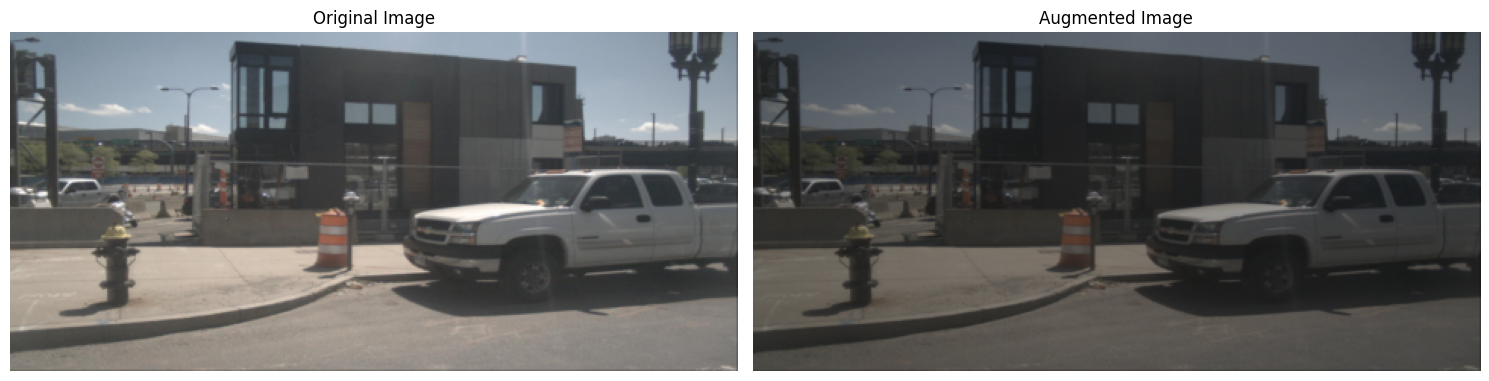

In [130]:
#from torchvision import transforms as T 
import torch
from utils.transforms import *
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import RandomErasing, ColorJitter

image_path = 'saved_models/m2f_large_b16_dri/output_images/b1r0_image.png'
image = Image.open(image_path).convert("RGB")
#transform = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05)
#transform = GaussianBlur(kernel_size=3, sigma=(0.5, 0.5))

class RandomColorJitter(object):
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1, p=0.5):
        self.transform = ColorJitter(brightness, contrast, saturation, hue)
        self.p = p
    
    def __call__(self, image, mask):
        if random.random() < self.p:
            image = self.transform(image)
        return image, mask

class MultiRandomErasing(object):
    def __init__(self, scale=(0.01, 0.02), ratio=(0.3, 3.3), values=(0, 1), max_nums=1, p1=0.5, p2=0.5):
        #value = random.uniform(values[0], values[1])
        #self.transform = RandomErasing(p, scale, ratio, value)
        self.max_nums = max_nums
        self.scale = scale
        self.ratio = ratio
        self.values = values
        self.p1 = p1
        self.p2 = p2
        
    def __call__(self, image, mask):
        if random.random() < self.p1:
            for _ in range(self.max_nums):
                value = random.uniform(self.values[0], self.values[1])
                transform = RandomErasing(p=self.p2, scale=self.scale, ratio=self.ratio, value=value)
                image = transform(image)
                #image = self.transform(image)
        return image, mask
    
h, w = 224,480 #448,800
transform = Compose([
    Resize((h, w)),
    RandomColorJitter(brightness=(0.3, 1.2), contrast=0.0, saturation=0.0, hue=0.05, p=1.0),  
    #GaussianBlur(kernel_size=5, sigma=(0.1, 0.11), p=1),
    ToTensor(),
    # T.RandomErasing(p=1, scale=(0.01, 0.02), ratio=(0.3, 3.3), value=random.random()),
    # T.RandomErasing(p=1, scale=(0.01, 0.02), ratio=(0.3, 3.3), value=random.random())
    #MultiRandomErasing(scale=(0.005, 0.01), ratio=(0.3, 3.3), values=(0.1, 1), max_nums=5, p1=1, p2=0.6)
])
mask = torch.randn(2,h, w)
augmented_image = transform(image, mask)
augmented_image = augmented_image[0].permute(1,2,0)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off") 
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 위치
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:

image_path = 'saved_models/m2f_large_b16_dri/output_images/b1r0_image.png'
image = Image.open(image_path).convert("RGB")
#transform = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05)
#transform = GaussianBlur(kernel_size=3, sigma=(0.5, 0.5))

class RandomColorJitter(object):
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1, p=0.5):
        self.transform = ColorJitter(brightness, contrast, saturation, hue)
        self.p = p
    
    def __call__(self, image, mask):
        if random.random() < self.p:
            image = self.transform(image)
        return image, mask

class MultiRandomErasing(object):
    def __init__(self, scale=(0.01, 0.02), ratio=(0.3, 3.3), values=(0, 1), max_nums=1, p1=0.5, p2=0.5):
        #value = random.uniform(values[0], values[1])
        #self.transform = RandomErasing(p, scale, ratio, value)
        self.max_nums = max_nums
        self.scale = scale
        self.ratio = ratio
        self.values = values
        self.p1 = p1
        self.p2 = p2
        
    def __call__(self, image, mask):
        if random.random() < self.p1:
            for _ in range(self.max_nums):
                value = random.uniform(self.values[0], self.values[1])
                transform = RandomErasing(p=self.p2, scale=self.scale, ratio=self.ratio, value=value)
                image = transform(image)
                #image = self.transform(image)
        return image, mask
    
h, w = 224,480 #448,800
transform = Compose([
    Resize((h, w)),
    RandomColorJitter(brightness=0.3, contrast=0.0, saturation=0.0, hue=0.05, p=1.0),  
    ToTensor(),
    # T.RandomErasing(p=1, scale=(0.01, 0.02), ratio=(0.3, 3.3), value=random.random()),
    # T.RandomErasing(p=1, scale=(0.01, 0.02), ratio=(0.3, 3.3), value=random.random())
    #MultiRandomErasing(scale=(0.005, 0.01), ratio=(0.3, 3.3), values=(0.1, 1), max_nums=5, p1=1, p2=0.6)
])
mask = torch.randn(2,h, w)
augmented_image = transform(image, mask)
augmented_image = augmented_image[0].permute(1,2,0)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off") 
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 위치
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis("off")
plt.tight_layout()
plt.show()

In [58]:
image.shape

(224, 480, 3)

In [67]:
image.shape[0]

900

In [2]:
!pip install Pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.4 MB/s eta 0:00:00


In [3]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np


image_path = '/home/etri/DATASET/nuscenes/samples/CAM_FRONT/n008-2018-05-21-11-06-59-0400__CAM_FRONT__1526915243012465.jpg'
image = np.array(Image.open(image_path).convert("RGB"))
h, w = 224,480
top_crop = 46

transforms = A.Compose([
            A.Resize(h+top_crop, w),  # Resize image and mask
            #A.HorizontalFlip(p=0.5),  # Random horizontal flip
            A.ColorJitter(brightness=0.9, contrast=0.0, saturation=0.0, hue=0.05, p=1),  # Random color jitter
            #A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0.1, 2.0), p=1),  # Gaussian blur
            #A.RandomFog(alpha_coef=0.3, fog_coef_range=[0.3, 0.9], p=0.5),
            #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize image
            ToTensorV2()  # Convert to tensor
        ])

mask = np.random.randint(0, 2, (image.shape[0], image.shape[1]), dtype=np.int32)
print(image.shape, mask.shape)
print(f"Type of image: {type(image)}")  # NumPy 배열인지 확인
print(f"Type of mask: {type(mask)}")    # NumPy 배열인지 확인
augmented = transforms(image=image, mask=mask)
transformed_image, transformed_mask = augmented['image'], augmented['mask']


transformed_image = transformed_image[:, top_crop:, :]
print(transformed_image.shape)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off") 
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 위치
plt.imshow(transformed_image.permute(1,2,0))
plt.title("Augmented Image")
plt.axis("off")
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'albumentations'

In [ ]:
class_weights =torch.tensor([
            args.w_bg,     # background (0)
            args.w_dri,    # dribeable (1)
            args.w_veh,    # vehicle (2)
            args.w_ped,    # pedestrian (3)
            0.1,           # non-object
        ])

In [1213]:
args.targets = ['driveable', 'vehicle'] #, 'pedestrian'

In [1214]:
args.w_bg = 1.0

In [1215]:
weight_dict = {'driveable': 2.0,
                'vehicle': 3.0,
                'pedestrian': 6.0
                }

In [1216]:
class_weights = [args.w_bg]
for target in args.targets:
    class_weights.append(weight_dict[target])
class_weights.append(0.1)
class_weights
    

[1.0, 2.0, 3.0, 0.1]

In [1210]:
torch.tensor(class_weights)

tensor([1.0000, 2.0000, 3.0000, 0.1000])

In [529]:
#predicted_semantic_map = torch.randint(0, 2, (224, 480), dtype=torch.int32)
#mask_labels = torch.randint(0, 2, (224, 480), dtype=torch.int32)

predicted_semantic_map = torch.zeros((224, 480), dtype=torch.int32)
mask_labels = torch.zeros((224, 480), dtype=torch.int32)

#predicted_semantic_map = torch.ones((224, 480), dtype=torch.int32)
#mask_labels = torch.ones((224, 480), dtype=torch.int32)

pred_binary = (predicted_semantic_map == 1)  # [H, W]
true_binary = (mask_labels == 1)   # [H, W]

intersection = (pred_binary & true_binary).sum()  
union = (pred_binary | true_binary).sum() 

print('intersection:', intersection.item())
print('union:', union.item())
valid_mask = (union > 0)
if valid_mask.any():
    iou = (intersection / union)
    print('iou:', iou.item())

intersection: 0
union: 0


In [530]:
torch.equal(pred_binary, true_binary)

True

In [523]:
valid_mask

tensor(True)

In [521]:
true_binary.any()

tensor(True)

In [77]:
import os
import time
import argparse
import logging
import wandb

import torch
from torch.utils.data import DataLoader
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

from nuimages import NuImages
from nuimages_dataset import NuImagesDataset

from utils.functions import *
from utils.engine import Solver
from utils.model_utils import collate_fn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, AutoImageProcessor, Mask2FormerForUniversalSegmentation

model_name = 'facebook/mask2former-swin-large-cityscapes-semantic'
num_classes = 3
img_h = 224
img_w = 480

processor = AutoImageProcessor.from_pretrained(model_name)
processor.num_labels = num_classes
processor.size['height'] = img_h
processor.size['width'] = img_w

id2label = {
    "0": "background",
    "1": "vehicle",
    "2": "road",
    "3": "pedestrian"
}
label2id = {
    "background" : 0,
    "vehicle": 1,
    "road": 2,
    "pedestrian": 3
  }

model = Mask2FormerForUniversalSegmentation.from_pretrained(
        model_name,
        num_labels=num_classes+1,  # 4개 클래스
        ignore_mismatched_sizes=True,
        # id2label = id2label,
        # label2id = label2id
    )

class_weights =torch.tensor([
    0.0,    # background (0)
    1.0,    # vehicle (1)
    1.0,    # road (2)
    5.0,    # pedestrian (3)
])


model.config.class_weight = class_weights

/home/etri/miniconda3/envs/cvt/lib/python3.8/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
processor = AutoImageProcessor.from_pretrained(model_name)

In [86]:
target_tag = 'DVP'
targets = []
if 'D' in target_tag :
    targets.append('driveable')
if 'V' in target_tag :
    targets.append('vehicle')
if 'P' in target_tag :
    targets.append('pedestrian')

targets

['driveable', 'vehicle', 'pedestrian']

In [772]:
class_weights =torch.tensor([
    1.0,    # background (0)
    3.0,    # vehicle (1)
    2.0,    # road (2)
    6.0,    # pedestrian (3)
    0.1,    # non-object
])

model.criterion.empty_weight = class_weights

In [773]:
model.criterion.empty_weight

tensor([1.0000, 3.0000, 2.0000, 6.0000, 0.1000])

In [766]:
import torch.nn as nn
import torch.functional as F
from transformers.models.mask2former.modeling_mask2former import Mask2FormerForUniversalSegmentation, Mask2FormerLoss
from torch import Tensor
from typing import Dict, List, Tuple

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction="none")
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()
    
class Mask2FormerFocalLoss(Mask2FormerLoss):
    def __init__(self, config, weight_dict, class_weights):
        super().__init__(config, weight_dict)
        self.class_weights = class_weights

    def loss_labels(
        self, class_queries_logits: Tensor, class_labels: List[Tensor], indices: Tuple[np.array]
    ) -> Dict[str, Tensor]:

        pred_logits = class_queries_logits
        batch_size, num_queries, _ = pred_logits.shape

        # criterion = nn.CrossEntropyLoss(weight=self.empty_weight)
        criterion = FocalLoss(weight=self.class_weights)

        idx = self._get_predictions_permutation_indices(indices)  # shape of (batch_size, num_queries)
        target_classes_o = torch.cat(
            [target[j] for target, (_, j) in zip(class_labels, indices)]
        )  # shape of (batch_size, num_queries)
        target_classes = torch.full(
            (batch_size, num_queries), fill_value=self.num_labels, dtype=torch.int64, device=pred_logits.device
        )
        target_classes[idx] = target_classes_o
        # Permute target_classes (batch_size, num_queries, num_labels) -> (batch_size, num_labels, num_queries)
        pred_logits_transposed = pred_logits.transpose(1, 2)
        loss_ce = criterion(pred_logits_transposed, target_classes)
        losses = {"loss_cross_entropy": loss_ce}
        return losses
    
class Mask2FormerFocal(Mask2FormerForUniversalSegmentation):
    def __init__(self, config, class_weights=None):
        # weight_dict 정의
        weight_dict = {"loss_cross_entropy": 2.0, "loss_mask": 5.0, "loss_dice": 5.0}
        if class_weights is None:
            class_weights = torch.tensor([0.0, 1.0, 1.0, 1.0])

        super().__init__(config)
        self.criterion = Mask2FormerFocalLoss(config, weight_dict, class_weights)

class_weights = torch.tensor([
    0.0,    # background (0)
    1.0,    # vehicle (1)
    1.0,    # road (2)
    5.0,    # pedestrian (3)
]) #.to(rank)

model = Mask2FormerFocal.from_pretrained(
    model_name,
    #class_weights=class_weights
)


In [760]:
model.criterion.weight_dict

{'loss_cross_entropy': 3.0, 'loss_mask': 5.0, 'loss_dice': 5.0}

In [726]:
dir(model.criterion.matcher)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_is_hf_initialized',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 '

In [727]:
dir(model.criterion.loss_labels)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [64]:
model = Mask2FormerForUniversalSegmentation.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes=True)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
model.class_predictor

Linear(in_features=256, out_features=3, bias=True)

In [11]:
image = torch.randn(8,3,224,480)
pixel_mask = torch.randint(0, 2, (8, 3, 224, 480), dtype=torch.int32)
outputs = model(
                pixel_values=image,
                pixel_mask=pixel_mask,
            )

In [18]:
target_sizes = [(224, 480)] *8

In [57]:
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

In [58]:
predicted_semantic_map[0].shape

torch.Size([224, 480])

In [26]:
torch.stack(predicted_semantic_map, dim=0).shape

torch.Size([8, 224, 480])

In [49]:
mask_label0 = torch.randint(0, 2, (4,4), dtype=torch.int32)
mask_label0

tensor([[1, 1, 0, 0],
        [0, 1, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 0]], dtype=torch.int32)

In [50]:
mask_label1 = mask_label0 *-1 +1

In [51]:
mask_label1

tensor([[0, 0, 1, 1],
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [0, 1, 0, 1]], dtype=torch.int32)

In [47]:
mask_label.shape

torch.Size([2, 4, 4])

In [55]:

mask_label = torch.stack([mask_label0, mask_label1], dim=0)
mask_label = mask_label.argmax(dim=0)

In [56]:
mask_label

tensor([[0, 0, 1, 1],
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [0, 1, 0, 1]])

In [42]:
print(dir(model.criterion))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_get_predictions_permutation_indices', '_get_targets_permutation_indices', '_is_full_backward_hook', '_is_hf_initialized', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_max_by_axis', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_pad_images_to_max_in_batch', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save

In [43]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# 원래 loss_labels 함수를 저장
original_loss_labels = model.criterion.loss_labels

# Focal Loss를 포함한 새로운 loss_labels 함수 정의
def new_loss_labels(self, *args, **kwargs):
    # 원래 loss 계산 로직 유지
    original_outputs = original_loss_labels(self, *args, **kwargs)
    
    # Focal Loss 추가
    focal_loss_fn = FocalLoss(alpha=1.0, gamma=2.0).cuda()
    src_logits = kwargs.get('src_logits')
    target_classes = kwargs.get('target_classes')
    
    if src_logits is not None and target_classes is not None:
        focal_loss = focal_loss_fn(src_logits, target_classes)
        original_outputs['loss_ce'] = focal_loss
    
    return original_outputs

# 새로운 loss_labels 함수로 교체
model.criterion.loss_labels = types.MethodType(new_loss_labels, model.criterion)

NameError: name 'types' is not defined

In [47]:
print("Weight Dict:", model.criterion.weight_dict)

# loss_labels 함수의 입력 확인을 위한 테스트
def print_args(*args, **kwargs):
    print("Args:", args)
    print("Kwargs:", kwargs)
    return model.criterion.loss_labels(*args, **kwargs)

# 임시로 함수 래핑
original_loss_labels = model.criterion.loss_labels
model.criterion.loss_labels = print_args

# empty_weight 확인
print("Empty Weight:", model.criterion.empty_weight)

# num_labels 확인
print("Num Labels:", model.criterion.num_labels)

Weight Dict: {'loss_cross_entropy': 2.0, 'loss_mask': 5.0, 'loss_dice': 5.0}
Empty Weight: tensor([1.0000, 1.0000, 1.0000, 0.1000])
Num Labels: 3


In [56]:
print("Weight Dict:", model.criterion.weight_dict)

# loss_labels 함수의 입력 확인을 위한 테스트
def print_args(*args, **kwargs):
    print("Args:", args)
    print("Kwargs:", kwargs)
    return model.criterion.loss_labels(*args, **kwargs)

# 임시로 함수 래핑
original_loss_labels = model.criterion.loss_labels
model.criterion.loss_labels = print_args

# empty_weight 확인
print("Empty Weight:", model.criterion.empty_weight)

# num_labels 확인
print("Num Labels:", model.criterion.num_labels)

Weight Dict: {'loss_cross_entropy': 2.0, 'loss_mask': 5.0, 'loss_dice': 5.0}
Empty Weight: tensor([1.0000, 1.0000, 1.0000, 0.1000])
Num Labels: 3


In [55]:
import torch.nn as nn
import torch.nn.functional as F
import types

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# 원래 loss_labels 함수 저장
original_loss_labels = model.criterion.loss_labels

# class weights 설정 (empty_weight 활용)
class_weights = torch.tensor([
        1.2,    # vehicle (0)
        1.0,   # road+lane (1)
        4.0,    # pedestrian (2)
    ]).cuda()

# Focal Loss 인스턴스 생성
focal_loss_fn = FocalLoss(alpha=1.0, gamma=2.0, weight=class_weights).cuda()

# 새로운 loss_labels 함수 정의
def new_loss_labels(self, focal_loss_fn, src_logits, target_classes, *args, **kwargs):
    src_logits = src_logits.flatten(0, 1)
    target_classes = target_classes.flatten(0)
    
    # Focal Loss 계산
    loss_ce = focal_loss_fn(src_logits, target_classes)
    
    losses = {'loss_cross_entropy': loss_ce}
    return losses

# 새로운 loss_labels 함수로 교체
model.criterion.loss_labels = types.MethodType(new_loss_labels(focal_loss_fn), model.criterion)

In [49]:
model.criterion.loss_labels

<bound method new_loss_labels of Mask2FormerLoss(
  (matcher): Mask2FormerHungarianMatcher()
)>

In [16]:
import torch.nn as nn
import torch.nn.functional as F
num_classes = 3
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# Cross Entropy Loss만 Focal Loss로 교체
model.config.ignore_value = num_classes
focal_loss = FocalLoss(alpha=1.0, gamma=2.0).cuda()

for matcher in model.criterion.criteria:
    if hasattr(matcher, 'loss_ce'):  # Cross Entropy Loss만 교체
        original_weight = matcher.loss_weight['loss_ce']  # 기존 CE loss의 가중치 유지
        matcher.loss_ce = focal_loss
        matcher.loss_weight['loss_ce'] = original_weight  # 가중치 재설정

AttributeError: 'Mask2FormerModel' object has no attribute 'criterion'

In [15]:
model

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                      (valu